## Introduction

Working with these files can be a challenge, especially given their heterogeneous nature. Some preprocessing is required before they are ready for consumption by your CNN.

Fortunately, I participated in the LUNA16 competition as part of a university course on computer aided diagnosis, so I have some experience working with these files. At this moment we top the leaderboard there :)

**This tutorial aims to provide a comprehensive overview of useful steps to take before the data hits your ConvNet/other ML method.**

What we will cover:  

* **Loading the DICOM files**, and adding missing metadata  
* **Converting the pixel values to *Hounsfield Units (HU)***, and what tissue these unit values correspond to
* **Resampling** to an isomorphic resolution to remove variance in scanner resolution.
* **3D plotting**, visualization is very useful to see what we are doing.
* **Lung segmentation**
* **Normalization** that makes sense.
* **Zero centering** the scans.


---

Before we start, let's import some packages and determine the available patients.

In [32]:
%matplotlib inline

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import dicom
from dicom import filereader as dicom_filereader
import os, glob
import scipy.ndimage
import matplotlib.pyplot as plt
import pywt

from skimage import measure, morphology
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# Some constants 
INPUT_FOLDER = '/media/mike/tera/data/databowl/'
patients = os.listdir(INPUT_FOLDER)
patients.sort()

# Loading the files
Dicom is the de-facto file standard in medical imaging. This is my first time working with it, but it seems to be fairly straight-forward.  These files contain a lot of metadata (such as the pixel size, so how long one pixel is in every dimension in the real world). 

This pixel size/coarseness of the scan differs from scan to scan (e.g. the distance between slices may differ), which can hurt performance of CNN approaches. We can deal with this by isomorphic resampling, which we will do later.

Below is code to load a scan, which consists of multiple slices, which we simply save in a Python list. Every folder in the dataset is one scan (so one patient). One metadata field is missing, the pixel size in the Z direction, which is the slice thickness. Fortunately we can infer this, and we add this to the metadata.

In [28]:
# Load the scans in given folder path
def load_scan(path):
    filepaths = [path + '/' + s for s in os.listdir(path)]
    slices = [dicom_filereader.read_file(p) for p in filepaths]
    metas = [dicom_filereader.read_file_meta_info(p) for p in filepaths]
    slices.sort(key = lambda x: int(x.InstanceNumber))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)
        
    for s in slices:
        s.SliceThickness = slice_thickness
        
    return slices, metas

The unit of measurement in CT scans is the **Hounsfield Unit (HU)**, which is a measure of radiodensity. CT scanners are carefully calibrated to accurately measure this.  From Wikipedia:

![HU examples][1]

By default however, the returned values are not in this unit. Let's fix this.

Some scanners have cylindrical scanning bounds, but the output image is square. The pixels that fall outside of these bounds get the fixed value -2000. The first step is setting these values to 0, which currently corresponds to air. Next, let's go back to HU units, by multiplying with the rescale slope and adding the intercept (which are conveniently stored in the metadata of the scans!).

  [1]: http://i.imgur.com/4rlyReh.png

In [25]:
dicom_filereader.read_file_meta_info(INPUT_FOLDER + '/' + patients[0] + '/'+ os.listdir(INPUT_FOLDER+patients[0])[0])

(0002, 0000) File Meta Information Group Length  UL: 190
(0002, 0001) File Meta Information Version       OB: '\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.840.113654.2.55.84837488424194986707789828379529479291
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.31'

In [3]:
def get_pixels_hu(scans):
    image = np.stack([s.pixel_array for s in scans])
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
    # Convert to Hounsfield units (HU)
    intercept = scans[0].RescaleIntercept
    slope = scans[0].RescaleSlope
    
    if slope != 1:
        image = slope * image.astype(np.float64)
        image = image.astype(np.int16)
        
    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

Let's take a look at one of the patients.

In [29]:
first_patient, metas = load_scan(INPUT_FOLDER + patients[0])
first_patient_pixels = get_pixels_hu(first_patient)
print(INPUT_FOLDER, patients[0])
# plt.hist(first_patient_pixels.flatten(), bins=80, color='c')
# plt.xlabel("Hounsfield Units (HU)")
# plt.ylabel("Frequency")
# plt.show()

# # Show some slice in the middle
# plt.imshow(first_patient_pixels[80], cmap=plt.cm.gray)
# plt.show()

('/media/mike/tera/data/databowl/', '00cba091fa4ad62cc3200a657aeb957e')


Looking at the table from Wikipedia and this histogram, we can clearly see which pixels are air and which are tissue. We will use this for lung segmentation in a bit :)


----------

In [5]:
# Test out writing to dicom
# print(type(first_patient_pixels), type(first_patient[0]), first_patient_pixels.shape)
# print(os.getcwd())
# dicom.write_file('dicom_test', first_patient_pixels)

In [6]:
import dicom, dicom.UID
# from dicom.dataset import Dataset, FileDataset
# from dicom import dataset
import numpy as np
import datetime, time
from imp import reload

In [7]:
target = getattr(dicom, '__cached__')
target = os.path.dirname(target)
target = glob.glob(target + '/*.pyc')
print(target)
[os.remove(targ) for targ in target]
print('')

AttributeError: 'module' object has no attribute '__cached__'

In [8]:
ls /home/mike/ve/ml/lib/python3.5/site-packages/dicom/__pycache__

__init__.cpython-35.pyc


In [9]:
reload(dicom)
# reload(dataset)
# reload(FileDataset)

def write_dicom(pixel_array,filename):
    """
    INPUTS:
    pixel_array: 2D numpy ndarray.  If pixel_array is larger than 2D, errors.
    filename: string name for the output file.
    """

    ## This code block was taken from the output of a MATLAB secondary
    ## capture.  I do not know what the long dotted UIDs mean, but
    ## this code works.
    file_meta = dicom.dataset.Dataset()
    file_meta.MediaStorageSOPClassUID = 'Secondary Capture Image Storage'
    file_meta.MediaStorageSOPInstanceUID = '1.3.6.1.4.1.9590.100.1.1.111165684411017669021768385720736873780'
    file_meta.ImplementationClassUID = '1.3.6.1.4.1.9590.100.1.0.100.4.0'
    ds = dicom.dataset.FileDataset(filename, {},file_meta = file_meta,preamble="\0"*128)
    ds.Modality = 'WSD'
    ds.ContentDate = str(datetime.date.today()).replace('-','')
    ds.ContentTime = str(time.time()) #milliseconds since the epoch
    ds.StudyInstanceUID =  '1.3.6.1.4.1.9590.100.1.1.124313977412360175234271287472804872093'
    ds.SeriesInstanceUID = '1.3.6.1.4.1.9590.100.1.1.369231118011061003403421859172643143649'
    ds.SOPInstanceUID =    '1.3.6.1.4.1.9590.100.1.1.111165684411017669021768385720736873780'
    ds.SOPClassUID = 'Secondary Capture Image Storage'
    ds.SecondaryCaptureDeviceManufctur = 'Python 2.7.3'

    ## These are the necessary imaging components of the FileDataset object.
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.PixelRepresentation = 0
    ds.HighBit = 15
    ds.BitsStored = 16
    ds.BitsAllocated = 16
    ds.SmallestImagePixelValue = '\\x00\\x00'
    ds.LargestImagePixelValue = '\\xff\\xff'
    ds.Columns = pixel_array.shape[0]
    ds.Rows = pixel_array.shape[1]
    if pixel_array.dtype != np.uint16:
        pixel_array = pixel_array.astype(np.uint16)
#     ds.PixelData = pixel_array.tostring()
    ds.PixelData = pixel_array.tobytes()

    
    ds.save_as(filename)
    return

print(first_patient_pixels.dtype, first_patient_pixels.shape)

(dtype('int16'), (134, 512, 512))


In [33]:
first_patient_wp = pywt.dwtn(first_patient_pixels, 'db4')

In [34]:
first_patient_wp

{'aaa': array([[[-2896.30937574, -2896.30937574, -2896.30937574, ...,
          -2896.30937574, -2896.30937574, -2896.30937574],
         [-2896.30937574, -2896.30937574, -2896.30937574, ...,
          -2896.30937574, -2896.30937574, -2896.30937574],
         [-2896.30937574, -2896.30937574, -2896.30937574, ...,
          -2896.30937574, -2896.30937574, -2896.30937574],
         ..., 
         [-2896.30937574, -2896.30937574, -2896.30937574, ...,
          -2896.30937574, -2896.30937574, -2896.30937574],
         [-2896.30937574, -2896.30937574, -2896.30937574, ...,
          -2896.30937574, -2896.30937574, -2896.30937574],
         [-2896.30937574, -2896.30937574, -2896.30937574, ...,
          -2896.30937574, -2896.30937574, -2896.30937574]],
 
        [[-2896.30937574, -2896.30937574, -2896.30937574, ...,
          -2896.30937574, -2896.30937574, -2896.30937574],
         [-2896.30937574, -2896.30937574, -2896.30937574, ...,
          -2896.30937574, -2896.30937574, -2896.30937574],

In [17]:
# python3 incompatibility due to the way strings/bytes are handled
subpath = 'test_dicom/'
for i, slc in enumerate(first_patient_pixels):
    write_dicom(slc, subpath + 'test_dicom{:03}.dcm'.format(i))

In [37]:
for key in first_patient_wp:
    subpath = 'test_dicom' + key + '/'
    try: 
        os.mkdir(subpath)
    except:
        pass
    for i, slc in enumerate(first_patient_wp[key]):
        write_dicom(slc, subpath + 'test_dicom{:03}.dcm'.format(i))

In [11]:
os.getcwd()

'/home/mike/py/kaggle/kaggle_data_bowl'

In [ ]:
assert 0, 'halt'

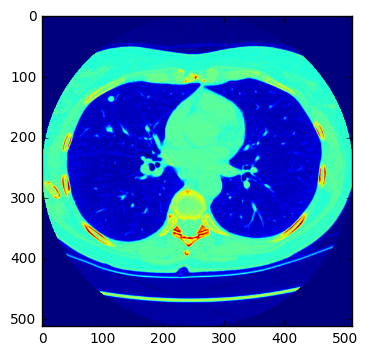

In [45]:
plt.imshow(first_patient_pixels[64])

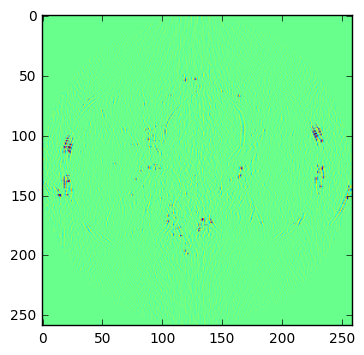

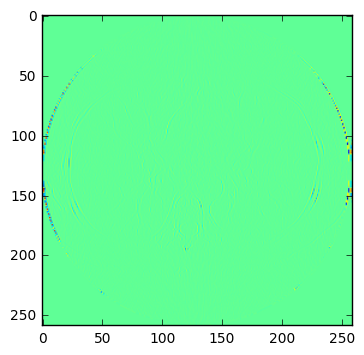

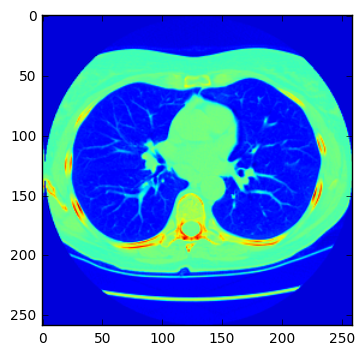

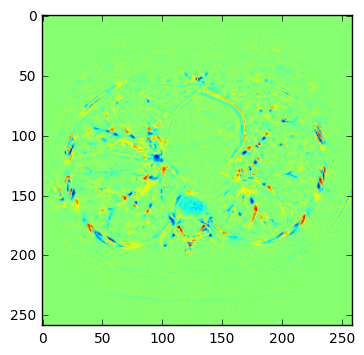

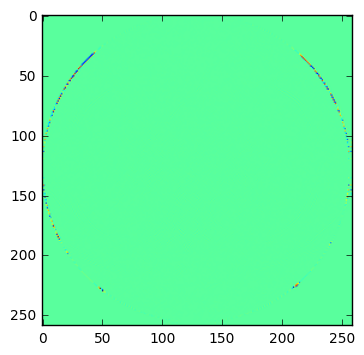

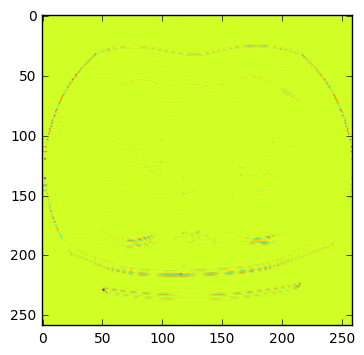

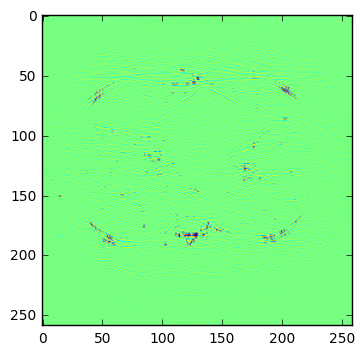

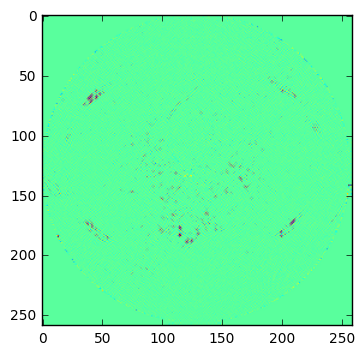

In [44]:
for key in first_patient_wp:
    plt.imshow(first_patient_wp[key][32])
    plt.show()

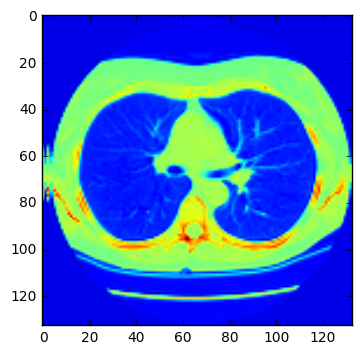

In [48]:
wp2 = pywt.dwtn(first_patient_wp['aaa'], 'db4')
plt.imshow(wp2['aaa'][16])

In [50]:
for key in wp2:
    subpath = 'test_dicom_2_' + key + '/'
    try: 
        os.mkdir(subpath)
    except:
        pass
    for i, slc in enumerate(wp2[key]):
        write_dicom(slc, subpath + 'test_dicom{:03}.dcm'.format(i))

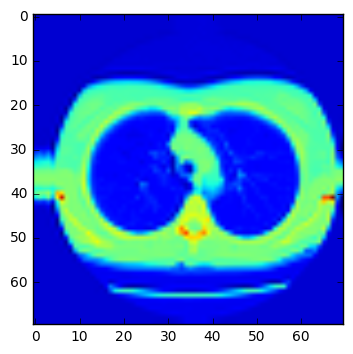

In [54]:
wp3 = pywt.dwtn(wp2['aaa'], 'db4')
plt.imshow(wp3['aaa'][8])

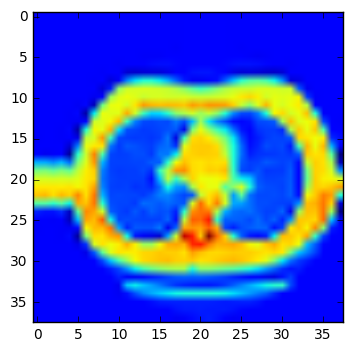

In [53]:
wp4 = pywt.dwtn(wp3['aaa'], 'db4')
plt.imshow(wp4['aaa'][8])

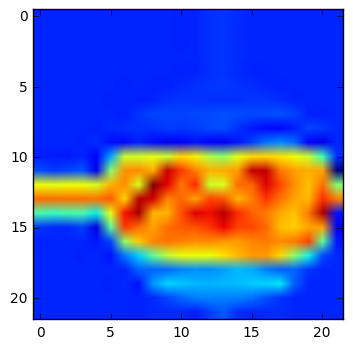

In [56]:
wp5 = pywt.dwtn(wp4['aaa'], 'db4')
plt.imshow(wp5['aaa'][4])

In [58]:
for key in wp3:
    subpath = 'test_dicom_3_' + key + '/'
    try: 
        os.mkdir(subpath)
    except:
        pass
    for i, slc in enumerate(wp3[key]):
        write_dicom(slc, subpath + 'test_dicom{:03}.dcm'.format(i))

# Resampling
A scan may have a pixel spacing of `[2.5, 0.5, 0.5]`, which means that the distance between slices is `2.5` millimeters. For a different scan this may be `[1.5, 0.725, 0.725]`, this can be problematic for automatic analysis (e.g. using ConvNets)! 

A common method of dealing with this is resampling the full dataset to a certain isotropic resolution. If we choose to resample everything to 1mm*1mm*1mm pixels we can use 3D convnets without worrying about learning zoom/slice thickness invariance. 

Whilst this may seem like a very simple step, it has quite some edge cases due to rounding. Also, it takes quite a while.

Below code worked well for us (and deals with the edge cases):

In [ ]:
def resample(image, scan, new_spacing=[1,1,1], verbose=False):
    # Determine current pixel spacing
    spacing = map(float, ([scan[0].SliceThickness] + scan[0].PixelSpacing))
    spacing = np.array(list(spacing))
#     spacing = np.array(float(scan[0].SliceThickness) 
#                        + float(scan[0].PixelSpacing[0]) + float(scan[0].PixelSpacing[1]))

    if verbose: print('Initial Spacing:', spacing)
    resize_factor = spacing / new_spacing
    new_real_shape = image.shape * resize_factor
    new_shape = np.round(new_real_shape)
    real_resize_factor = new_shape / image.shape
    new_spacing = spacing / real_resize_factor
    if verbose: print('RRF: {} RF: {}'.format(real_resize_factor, resize_factor))
    
    image = scipy.ndimage.interpolation.zoom(image, real_resize_factor)
    
    return image, new_spacing